## Semantic Search using Universal Sentence Encoder [USE](https://amitness.com/2020/06/universal-sentence-encoder/)
- Transformer Encoder
- Deep Averaging Network(DAN) Encoder

### [CISI Dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval)


In [ ]:
import os
import pandas as pd
#Libraries for universal sentence encoder
import tensorflow_hub as hub
#Libraries for cosine similarity
import numpy as np
from numpy.linalg import norm
#Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

### 1.Load Dataset Files

In [ ]:
def load_data():
    import os
    # upload files
    path = r"/content"

    #_____________ Read data from CISI.ALL file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.ALL')) as f:
        lines = ""
        for l in f.readlines():
            # add new line char for lines starting with (.) and add space for other lines
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        #split a string into list based on newline(\n) separator.
        lines = lines.lstrip("\n").split("\n")

    # Put each DOCUMENT into a dictionary doc_set
    doc_set = {}
    doc_id = ""
    doc_text = ""

    for l in lines:
        if l.startswith(".I"):
            doc_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".X"):
            # indicate document ending
            doc_set[doc_id] = doc_text.lstrip(" ")
            doc_id = ""
            doc_text = ""
        else:
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            doc_text += l.strip()[3:] + " "

    print(f"Number of documents = {len(doc_set)}")
    print(doc_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.QRY file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.QRY')) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")

    # Put each QUERY into a dictionary doc_set.
    qry_set = {}
    qry_id = ""
    for l in lines:
        if l.startswith(".I"):
            qry_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".W"):
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            qry_set[qry_id] = l.strip()[3:]
            qry_id = ""

    print(f"\n\nNumber of queries = {len(qry_set)}")
    print(qry_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.REL file and store in dictinary ________________

    rel_set = {}
    with open(os.path.join(path, 'CISI.REL')) as f:
        for l in f.readlines():
            qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0] #split("\t")[0] -> '1     28'
            doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1] #                 [0]   [-1]

            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)

    print(f"\n\nNumber of mappings = {len(rel_set)}")
    print(rel_set["1"]) # note that the dictionary indexes are strings, not numbers.

    return doc_set, qry_set, rel_set

In [ ]:
# returns dictionary with key->doc_id/query_id and value->data
doc_set, qry_set, rel_set = load_data()

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '1

#### 2.1 Length of documents and Queries

In [ ]:
def get_length(doc_set, qry_set):
    # Length of documents
    min_d = 9999
    max_d = 0
    for i in doc_set:
        min_d = min(min_d, len(doc_set[i]))
        max_d = max(max_d, len(doc_set[i]))
    print(f"Doc length\n no. of characters min: {min_d}, max: {max_d}")

    # Length of queries
    min_q = 9999
    max_q = 0
    for i in qry_set:
        min_d = min(min_q, len(qry_set[i]))
        max_d = max(max_q, len(qry_set[i]))
    print(f"\nQuery length\n no. of characters min: {min_d}, max: {max_d}")

In [ ]:
get_length(doc_set, qry_set)

Doc length
 no. of characters min: 99, max: 3903

Query length
 no. of characters min: 432, max: 432


In [ ]:
doc_set['1']

"18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. "

In [ ]:
qry_set['1']

'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'

### 2.Load Pretrained Universal Sentence Encoder <a id="load_data">

In [ ]:
'''
The "universal-sentence-encoder" model is trained with a deep averaging network (DAN) encoder.
The "universal-sentence-encoder-large" model is trained with a Transformer encoder.
'''
module_urls= {}
module_urls['dan_encoder'] = "https://tfhub.dev/google/universal-sentence-encoder/4"
module_urls['transformer_encoder'] = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

In [ ]:
#Load Universal Sentence Encoder model
#use_model1 = hub.load(module_urls['dan_encoder'])
use_model2 = hub.load(module_urls['transformer_encoder'])

### 3.Data Modelling <a id='train_nn_system'>

#### 3.1. Create embedding vector for each document by using Universal Sentence Encoder model <a id='3.1'>

##### 3.1.1.DAN Encoder

In [ ]:
#Create embedding of a doc/query
def get_dan_encoder_embeddings(data):
  return use_model1(data)

In [ ]:
#Create embeddings of all documents in this dataset
embeddings = get_dan_encoder_embeddings(list(doc_set.values()))
docs_embeddings1 = {doc_id:embedding for embedding, doc_id in zip(embeddings, doc_set)}

In [ ]:
#Create embeddings of all queries in this dataset
embeddings = get_dan_encoder_embeddings(list(qry_set.values()))
query_embeddings1 = {qry_id:embedding for embedding, qry_id in zip(embeddings, qry_set)}

In [ ]:
print(f"doc embedding length: {len(docs_embeddings1['1'])}") #512
print(f"query embedding length: {len(query_embeddings1['1'])}") #512

##### 3.1.2.Transformer Encoder

In [ ]:
#Create embedding of a doc/query
def get_transformer_encoder_embeddings(data):
  return use_model2(data)

In [ ]:
#Create embeddings of all documents in this dataset
'''As model takes vector i/p add dimension to i/p and remove dimension from o/p'''
docs_embeddings2 = {doc_id:use_model2([doc])[0] for (doc_id, doc) in doc_set.items()}
#tensor to list
docs_embeddings2 = {doc_id:np.array(doc).tolist() for (doc_id, doc) in docs_embeddings2.items()}

In [ ]:
#Create embeddings of all queries in this dataset
embeddings = get_transformer_encoder_embeddings(list(qry_set.values()))
query_embeddings2 = {qry_id:embedding for embedding, qry_id in zip(embeddings, qry_set)}

In [ ]:
print(f"doc embedding length: {len(docs_embeddings2['1'])}") #512
print(f"query embedding length: {len(query_embeddings2['1'])}") #512

doc embedding length: 512
query embedding length: 512


#### 3.2. Compute cosine similarity between docs and query <a id='3.2'>



In [ ]:
#Compute the cosine similarity between a batch of vectors and a vector(1-D NumPy array)
def cosine_similarity(A, B):
  cosine_similarities = np.dot(A,B)/(norm(A, axis=1)*norm(B))
  return cosine_similarities

In [ ]:
def get_sorted_docid_per_query(doc_scores, doc_set):
    docid_sortedBy_score = {} #key-> query_id, value-> list of doc_id in descending order of doc scores

    for query_id in doc_scores:
        # dictionary, key->doc_id and value->doc score
        doc_score_dict = {}
        for score, doc_id in zip(doc_scores[query_id], doc_set):
            doc_score_dict[doc_id] = round(score, 4)

        # sort doc_id based on scores, high score first
        # sorted(..,key=function) function transforms each element before sorting, it takes the value and returns 1 value which is then used within sort instead of the original value.
        docid_sortedBy_score[query_id] = sorted(doc_score_dict, key=doc_score_dict.get, reverse=True)
        #print(f"query_id: {query_id}")

    return docid_sortedBy_score

##### 3.2.1.DAN Encoder

In [ ]:
#Calculate similarities between query and docs {key->query_id, value->list of doc scores}
doc_scores1 = {qry_id:cosine_similarity(list(docs_embeddings1.values()), query_embeddings1[qry_id]) for qry_id in qry_set.keys()}

In [ ]:
doc_scores1 = get_sorted_docid_per_query(doc_scores1, doc_set)
print(doc_scores1['1'])

['429', '722', '582', '589', '1281', '1195', '219', '176', '650', '377', '11', '1392', '1118', '29', '888', '1000', '1215', '1422', '1138', '38', '1152', '465', '820', '478', '676', '1323', '657', '64', '334', '1299', '86', '958', '215', '1224', '753', '901', '342', '541', '487', '1055', '84', '666', '784', '1349', '138', '1448', '1115', '236', '1165', '1277', '904', '825', '258', '58', '1097', '1091', '347', '992', '604', '412', '1210', '1124', '603', '1001', '212', '68', '70', '247', '869', '381', '1248', '776', '1059', '16', '553', '451', '587', '1170', '1197', '1212', '1350', '725', '573', '1054', '63', '210', '266', '1090', '472', '457', '6', '1381', '715', '1276', '1268', '882', '47', '1160', '361', '110', '802', '554', '571', '445', '52', '35', '712', '319', '363', '1351', '1098', '461', '259', '28', '813', '1024', '447', '480', '1182', '830', '1163', '1431', '1427', '811', '794', '257', '34', '1046', '1196', '135', '1245', '538', '590', '643', '660', '805', '920', '1131', '816'

##### 3.2.2.Transformer Encoder

In [ ]:
#Calculate similarities between query and docs {key->query_id, value->list of doc scores}
doc_scores2 = {qry_id:cosine_similarity(list(docs_embeddings2.values()), query_embeddings2[qry_id]) for qry_id in qry_set.keys()}

In [ ]:
doc_scores2 = get_sorted_docid_per_query(doc_scores2, doc_set)
print(doc_scores2['1'])

['650', '1323', '429', '1195', '722', '510', '1162', '582', '1000', '783', '992', '258', '1281', '176', '1164', '212', '1280', '603', '38', '1161', '60', '29', '769', '596', '589', '715', '1421', '1167', '86', '489', '1392', '344', '1163', '600', '314', '1268', '1165', '805', '643', '1091', '784', '799', '662', '851', '1388', '1010', '1129', '324', '1431', '830', '88', '478', '219', '70', '1160', '52', '524', '680', '1414', '473', '907', '1131', '1196', '601', '649', '1382', '508', '287', '389', '451', '315', '415', '466', '1422', '714', '483', '1218', '1157', '1224', '447', '871', '516', '445', '1226', '527', '125', '221', '868', '577', '1395', '1215', '257', '503', '26', '110', '1046', '898', '1171', '869', '1257', '276', '901', '813', '576', '235', '1064', '1279', '790', '499', '467', '661', '193', '1059', '226', '767', '1364', '477', '1285', '1372', '719', '824', '148', '79', '420', '495', '35', '1134', '726', '770', '1448', '645', '1246', '757', '51', '1108', '744', '1089', '812',

### 4.Performance Metrics

#### 4.1 Recall@K [order-unaware]

In [ ]:
# Recall@K = TP/(TP+FN)
def recall_k(ground_truth, predictions, k):
  avg_recall = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(truth_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_recall += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_recall /= len(ground_truth)

  return round(avg_recall, 3)

In [ ]:
print(f"Recall of DAN Encoder\n")
print(f"Recall@5 = {recall_k(rel_set, doc_scores1, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, doc_scores1, 10)}") #Top-10 results

Recall of DAN Encoder

Recall@5 = 0.048
Recall@10 = 0.096


In [ ]:
print(f"Recall of Transformer Encoder\n")
print(f"Recall@5 = {recall_k(rel_set, doc_scores2, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, doc_scores2, 10)}") #Top-10 results

Recall of Transformer Encoder

Recall@5 = 0.063
Recall@10 = 0.092


#### 4.2 Precision@K [order-unaware]

In [ ]:
# Precision@K = TP/(TP+FP)
def precision_k(ground_truth, predictions, k):
  avg_precision = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_precision += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_precision /= len(ground_truth)

  return round(avg_precision, 3)

In [ ]:
print(f"Precision of DAN Encoder\n")
print(f"Precision@5 = {precision_k(rel_set, doc_scores1, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, doc_scores1, 10)}") #Top-10 results

Precision of DAN Encoder

Precision@5 = 0.311
Precision@10 = 0.274


In [ ]:
print(f"Precision of Transformer Encoder\n")
print(f"Precision@5 = {precision_k(rel_set, doc_scores2, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, doc_scores2, 10)}") #Top-10 results

Precision of Transformer Encoder

Precision@5 = 0.368
Precision@10 = 0.295


#### 4.3 Mean Reciprocal Rank (MRR) [order-aware]

In [ ]:
# first occurance of true positive i.e. index of first actual relevant docid predicted.
def get_first_relevent_docid(predictions, truth):
    for doc_id in predictions:
        is_exist = doc_id in truth #truth.count(doc_id)
        #print(f"predictions: {doc_id}, is_exist: {is_exist}")
        if is_exist:
            return predictions.index(doc_id)+1
    else:
        return -1

In [ ]:
def mrr(doc_scores, rel_set):
    Q = len(rel_set) # number of queries with known ground-truth
    cumulative_reciprocal = 0  # summation of reciprocals of the first actual relevant ranks

    for query_id in rel_set:
        # index of first actual relevant docid predicted
        first_result = get_first_relevent_docid(doc_scores[query_id], rel_set[query_id])
        # check if function returned index or -1 (for -1 use no. of docs+1 = 1461)
        first_result_rank = len(doc_scores['1'])+1 if first_result<1 else first_result
        reciprocal = 1 / first_result_rank
        cumulative_reciprocal += reciprocal
        #print(f"query #{query_id} = 1/{first_result} = {round(reciprocal,2)}")

    mrr = 1/Q * cumulative_reciprocal # mean of summation of cumulative_reciprocal
    return round(mrr,3)

In [ ]:
mrr = mrr(doc_scores1, rel_set)
print(f"Mean Reciprocal Rank (MRR) of DAN Encoder: {mrr}")

Mean Reciprocal Rank (MRR) of DAN Encoder: 0.555


In [ ]:
mrr = mrr(doc_scores2, rel_set)
print(f"Mean Reciprocal Rank (MRR) of Transformer Encoder: {mrr}")

Mean Reciprocal Rank (MRR) of Transformer Encoder: 0.578


#### 4.4 Mean Average Precision (MAP) [order-aware]

In [ ]:
def map_k(rel_set, doc_scores, K):
    Q = len(rel_set) # number of queries with known ground-truth
    avg_precision = [] #AP of all queries

    for query_id in rel_set:
        precision_relevance_summation = 0

        for k in range(0,K):
            # calculate precision@k
            truth_set = set(rel_set[query_id])
            pred_set = set(doc_scores[query_id][:k+1])
            precision_at_k = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
            # check relevance of predicted docid at k
            rel_k = 1 if doc_scores[query_id][k] in rel_set[query_id] else 0
            precision_relevance_summation += precision_at_k * rel_k # summation of precision*relevance
            #print(f"qid: {query_id}, k: {k}, precision_at_k : {precision_at_k}, rel_k : {rel_k}, ap_num: {ap_num}, docid_sortedBy_score[query_id][k]: {docid_sortedBy_score[query_id][k]}")

        # AP value of query qid
        avg_precision_q = precision_relevance_summation / len(rel_set[query_id])
        #print(f"len(rel_set[q]): {len(rel_set[query_id])}, AP@{K}_{int(query_id)} = {round(avg_precision_q,2)}")
        avg_precision.append(avg_precision_q)

    map_k = sum(avg_precision) / Q # mean of all AP values of a query
    return round(map_k, 3)

In [ ]:
print(f"MAP of DAN Encoder")
map_5 = map_k(rel_set, doc_scores1, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, doc_scores1, K=10)
print(f"MAP@10 = {map_10}")

MAP of DAN Encoder
MAP@5 = 0.035
MAP@10 = 0.051


In [ ]:
print(f"MAP of Transformer Encoder")
map_5 = map_k(rel_set, doc_scores2, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, doc_scores2, K=10)
print(f"MAP@10 = {map_10}")

MAP of Transformer Encoder
MAP@5 = 0.05
MAP@10 = 0.066


### 5.Performance Comparison of USE-DAN vs USE-Transformer
Universal Sentence Encoder using Deep Averaging Network (DAN) architecture vs Universal Sentence Encoder using Transformer architecture

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = {'model': ['USE-DAN', 'USE-Transformer'],
        'Recall@10': [0.096, 0.092],
        'Precision@10': [0.274, 0.295],
        'MRR': [0.555, 0.578],
        'MAP@10': [0.051, 0.066]
        }

df_performance = pd.DataFrame(data)
df_performance

,model,Recall@10,Precision@10,MRR,MAP@10
0,USE-DAN,0.096,0.274,0.555,0.051
1,USE-Transformer,0.092,0.295,0.578,0.066


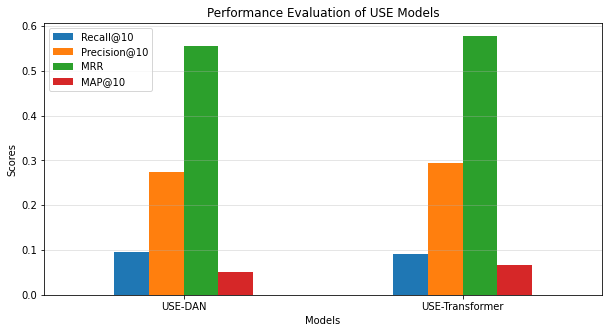

In [ ]:
df_performance.plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Performance Evaluation of USE Models')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

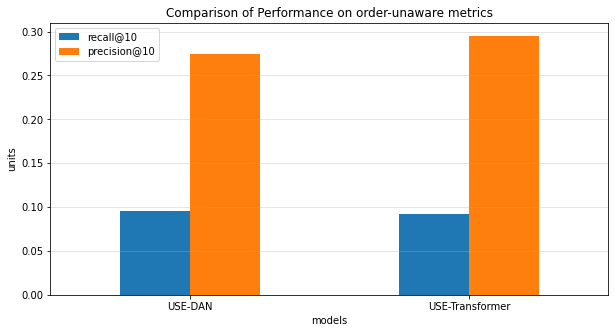

In [ ]:
df_performance[['model', 'recall@10', 'precision@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-unaware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

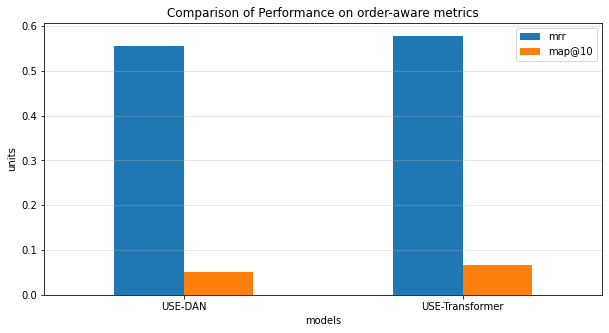

In [ ]:
df_performance[['model', 'mrr', 'map@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-aware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

### Best model: USE-Transformer